In [1]:
import os
work_path = os.getcwd()
os.chdir(os.path.join(work_path, "outputs/Izhikevich_hamker_1_neuron"))

from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest, compile_modules

In [2]:
compile_modules("izhikevich_hamker")

2020-12-22 15:53:27,009 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-12-22 15:53:27,009 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-12-22 15:53:27,023 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/izhikevich_hamker
into /home/docker/packages/nest_modules_builds/izhikevich_hamker...
2020-12-22 15:53:27,023 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/izhikevich_hamker
into /home/docker/packages/nest_modules_builds/izhikevich_hamker...
2020-12-22 15:53:27,077 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Compiling izhikev

In [3]:
nest = load_nest()
nest.SetKernelStatus({"overwrite_files": True})
nest.Install("izhikevich_hamkermodule")

2020-12-22 15:53:43,906 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Loading a NEST instance...
2020-12-22 15:53:43,906 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Loading a NEST instance...
2020-12-22 15:53:43,912 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-12-22 15:53:43,912 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-12-22 15:53:43,915 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-12-22 15:53:43,915 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-12-22 15:53:43,918 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/do

In [4]:
# nest.Models()

In [5]:
from copy import deepcopy
params_common = {"E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "c": -65.0,
                 "C_m": 1.0, "I_e": 0.0,
                 "t_ref": 10.0, "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
                 "n0": 140.0, "n1": 5.0, "n2": 0.04}
paramsI = deepcopy(params_common)
paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
paramsE = deepcopy(params_common)
paramsStr = deepcopy(params_common)
paramsStr.update({"V_th": 40.0, "C_m": 50.0,
                  "n0": 61.65, "n1": 2.59, "n2": 0.02,
                  "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

In [6]:
exc1 = nest.Create("izhikevich_hamker", 1, params=paramsE)

In [7]:
stimE = nest.Create("poisson_generator", 1, params={"rate": 10.0, "origin": 0.0, "start": 0.1})
nest.Connect(stimE, exc1, syn_spec={'weight': 1.0, 'delay': 1.0, "receptor_type": 0})

In [8]:
record_from = ["V_m", "U_m", "I_syn", "I_syn_ex", "I_syn_in", "g_L", "g_AMPA", "g_GABA_A"]
n_vars = len(record_from)
exc1_mltr = nest.Create("multimeter", 1, 
                        params={"record_from": record_from, "interval": 1.0, 
                                "record_to": "ascii", "label": "data"})
nest.Connect(exc1_mltr, exc1)
exc1_spikes_rec = nest.Create("spike_recorder", 1, params={"record_to": "ascii", "label": "spikes"})
nest.Connect(exc1, exc1_spikes_rec)

In [9]:
simulation_time = 10000.0 # ms
nest.Prepare()
nest.Run(simulation_time)
nest.GetKernelStatus("time")

10000.0

In [10]:
def read_data_as_recarray(filename):
    import numpy as np
    from numpy.lib.recfunctions import rename_fields
        
    def as_dict(rec):
        """ turn a numpy recarray record into a dict. this is mostly useful
            just to have a human readable output of a record on the console.
            as_dict(my_data[234])
        """
        return {name:rec[name] for name in rec.dtype.names}
    
    return as_dict(
                rename_fields(np.genfromtxt(filename, names=True, skip_header=2), 
                              {"sender": "senders", "time_ms": "times"}
                              )
                   )
    
    
def read_data_as_pandas_df(filename):
    import pandas as pd
    return pd.read_table(filename, header=2).\
                rename(columns={"sender": "senders", "time_ms": "times"}).to_dict("list")
    
    
def read_data_from_device(filename):
    try:
        return read_data_as_recarray(filename)
    except:
        return read_data_as_pandas_df(filename)

In [11]:
import time
tic = time.time()
events = read_data_as_recarray("data-3-0.dat")
print(time.time() - tic)
tic = time.time()
events = read_data_as_pandas_df("data-3-0.dat")
print(time.time() - tic)

0.10740113258361816
0.021533966064453125


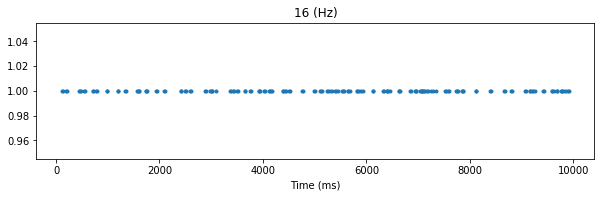

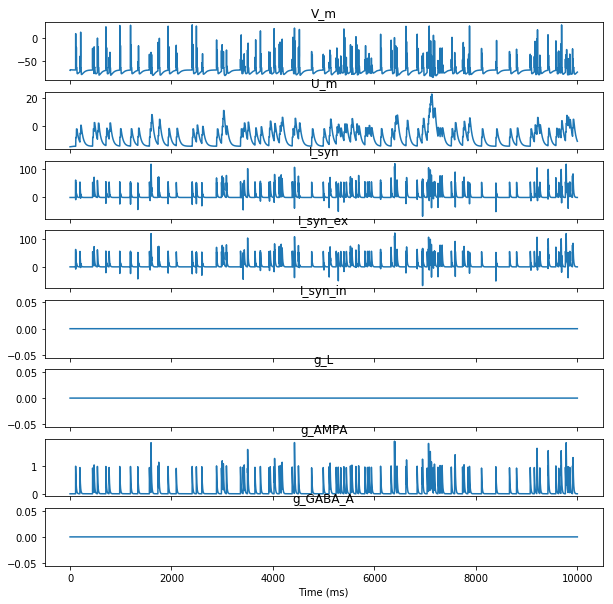

In [12]:
from matplotlib import pyplot
pyplot.close("all")
try:
    exc1_spikes = nest.GetStatus(exc1_spikes_rec)[0]["events"]
except:
    exc1_spikes = read_data_from_device("spikes-4-0.dat")
rate = len(exc1_spikes["times"]) / simulation_time * 1000
f1 = pyplot.figure(figsize=(10, 2.5))
pyplot.plot(exc1_spikes["times"], exc1_spikes["senders"], ".")
pyplot.xlabel("Time (ms)")
pyplot.title("%g (Hz)" % rate)
pyplot.show()
try:
    exc1_ts = nest.GetStatus(exc1_mltr)[0]["events"]
except:
    exc1_ts = read_data_from_device("data-3-0.dat")
f2, axes = pyplot.subplots(n_vars, 1, sharex=True, figsize=(10, 10))
for i_var, var in enumerate(record_from):
    varts = exc1_ts[var]
    ts = exc1_ts["times"]
    axes[i_var].plot(ts, varts)
    axes[i_var].set_title(var)
axes[-1].set_xlabel("Time (ms)")
pyplot.show()

In [13]:
exc1_ts["V_m"].max()

27.988

In [14]:
nest.GetDefaults("izhikevich_hamker")

{'a': 0.02,
 'archiver_length': 0,
 'available': (999,),
 'b': 0.2,
 'beta_Ca': 0.001,
 'C_m': 1.0,
 'Ca': 0.0,
 'c': -72.0,
 'capacity': (1000,),
 'consistent_integration': True,
 'd': 6.0,
 'E_rev_AMPA': 0.0,
 'E_rev_GABA_A': -90.0,
 'element_type': 'neuron',
 'elementsize': 720,
 'frozen': False,
 'g_AMPA': 0.0,
 'g_GABA_A': 0.0,
 'g_L': 0.0,
 'global_id': 0,
 'I': 0.0,
 'I_e': 0.0,
 'I_syn': 0.0,
 'I_syn_ex': 0.0,
 'I_syn_in': 0.0,
 'instantiations': (1,),
 'local': True,
 'model': 'izhikevich_hamker',
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'receptor_types': {'activity': 0, 'noise': 1},
 'recordables': ('g_AMPA',
  'g_GABA_A',
  'g_L',
  'I',
  'I_syn',
  'I_syn_ex',
  'I_syn_in',
  'U_m',
  'V_m'),
 'synaptic_elements': {},
 't_ref': 10.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'tau_rise': 1.0,
 'tau_rise_AMPA': 10.0,
 'tau_rise_GABA_A': 10.0,
 'thread': 0,
 'thread_local_id': -1,
 'type_id': 'izhikevich_hamker',
 'U_m': -14.

In [15]:
import pandas as pd
exc1_ts = pd.read_table("./data-3-0.dat", header=2).rename(columns={"sender": "Neuron", "time_ms": "Time"})
exc1_ts

,Neuron,Time,V_m,U_m,I_syn,I_syn_ex,I_syn_in,g_L,g_AMPA,g_GABA_A
0,1,1.0,-70.716,-14.397,0.000,0.000,-0.0,0.0,0.0,0.0
1,1,2.0,-70.077,-14.391,0.000,0.000,-0.0,0.0,0.0,0.0
2,1,3.0,-69.743,-14.383,0.000,0.000,-0.0,0.0,0.0,0.0
3,1,4.0,-69.567,-14.374,0.000,0.000,-0.0,0.0,0.0,0.0
4,1,5.0,-69.475,-14.365,0.000,0.000,-0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9994,1,9995.0,-74.922,-10.145,0.028,0.028,-0.0,0.0,0.0,0.0
9995,1,9996.0,-74.827,-10.241,0.025,0.025,-0.0,0.0,0.0,0.0
9996,1,9997.0,-74.733,-10.334,0.023,0.023,-0.0,0.0,0.0,0.0
9997,1,9998.0,-74.641,-10.426,0.021,0.021,-0.0,0.0,0.0,0.0


In [16]:
def read_dataframe_to_xarray(df):
    multiindex = pd.MultiIndex.from_tuples(list(exc1_ts.groupby([df.columns[1], df.columns[0]]).groups.keys()), 
                                           names=["Time", "Neuron"])
    arr = df[df.columns[2:]].to_xarray().to_array(dim="Variable")
    arr.coords["index"] = multiindex
    return arr.unstack("index").transpose("Time", "Variable", "Neuron")

In [17]:
exc1_ts_arr = read_dataframe_to_xarray(exc1_ts)
exc1_ts_arr

<xarray.DataArray (Time: 9999, Variable: 8, Neuron: 1)>
array([[[-7.0716e+01],
        [-1.4397e+01],
        [ 0.0000e+00],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.0077e+01],
        [-1.4391e+01],
        [ 0.0000e+00],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-6.9743e+01],
        [-1.4383e+01],
        [ 0.0000e+00],
        ...,
...
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.4641e+01],
        [-1.0426e+01],
        [ 2.1000e-02],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.4549e+01],
        [-1.0515e+01],
        [ 1.9000e-02],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]]])
Coordinates:
  * Variable  (Variable) <U8 'V_m' 'U_m' 'I_syn' ... 'g_L' 'g_AMPA' 'g_GABA_A'
  * Time      (Time) float64 1.0 2.0 3.0 4.0 ... 9.997e+03 9.998e+03 9.999e+03
  * Neuron    (Neuron) int64 1

In [18]:
def read_multimeter_data_to_xarray(filename):
    from pandas import read_table, MultiIndex
    df = read_table(filename, header=2)
    multiindex = MultiIndex.from_tuples(list(df.groupby([df.columns[1], df.columns[0]]).groups.keys()), 
                                           names=["Time", "Neuron"])
    arr = df[df.columns[2:]].to_xarray().to_array(dim="Variable")
    arr.coords["index"] = multiindex
    return arr.unstack("index").transpose("Time", "Variable", "Neuron")

In [19]:
read_multimeter_data_to_xarray("./data-3-0.dat")

<xarray.DataArray (Time: 9999, Variable: 8, Neuron: 1)>
array([[[-7.0716e+01],
        [-1.4397e+01],
        [ 0.0000e+00],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.0077e+01],
        [-1.4391e+01],
        [ 0.0000e+00],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-6.9743e+01],
        [-1.4383e+01],
        [ 0.0000e+00],
        ...,
...
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.4641e+01],
        [-1.0426e+01],
        [ 2.1000e-02],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]],

       [[-7.4549e+01],
        [-1.0515e+01],
        [ 1.9000e-02],
        ...,
        [ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00]]])
Coordinates:
  * Variable  (Variable) <U8 'V_m' 'U_m' 'I_syn' ... 'g_L' 'g_AMPA' 'g_GABA_A'
  * Time      (Time) float64 1.0 2.0 3.0 4.0 ... 9.997e+03 9.998e+03 9.999e+03
  * Neuron    (Neuron) int64 1

In [20]:
def read_device_data_to_events_dict(filename):
    from pandas import read_table
    return pd.read_table(filename, header=2).\
                    rename(columns={"sender": "senders", "time_ms": "times"}).to_dict("list")

In [21]:
events = read_device_data_to_events_dict("./data-3-0.dat")

In [22]:
import numpy as np
from collections import OrderedDict
from pandas import MultiIndex
from xarray import DataArray
from tvb.contrib.scripts.utils.data_structures_utils import ensure_list

def events_dict_to_xarray(events):

    multiindex = MultiIndex.from_tuples(list(zip(events["times"], events["senders"])), names=["Time", "Neuron"])
    events.pop("times"); events.pop("senders");
    arr = DataArray(np.stack(events.values()).T, dims=["TimeNeuron", "Variable"], 
                    coords={"TimeNeuron": multiindex, "Variable": list(events.keys())})
    return arr.unstack("TimeNeuron").transpose("Time", "Variable", "Neuron")


def data_xarray_from_continuous_events(events, times, senders, variables=[],
                                       filter_senders=None, exclude_senders=[], name=None,
                                       dims_names=["Time", "Variable", "Neuron"]):
    unique_times = np.unique(times).tolist()
    if filter_senders is None:
        filter_senders = np.unique(senders).tolist()
    else:
        filter_senders = np.unique(flatten_list(filter_senders)).tolist()
    exclude_senders = ensure_list(exclude_senders)
    for sender in exclude_senders:
        filter_senders.remove(sender)
    variables = ensure_list(variables)
    if len(variables) is None:
        variables = list(events.keys())
    dims_names = ensure_list(dims_names)
    coords = OrderedDict()
    coords[dims_names[0]] = unique_times
    coords[dims_names[1]] = variables
    coords[dims_names[2]] = filter_senders
    n_senders = len(filter_senders)
    n_times = len(unique_times)
    data = np.empty((n_times, len(variables), n_senders))
    last_time = times[0]
    i_time = unique_times.index(last_time)
    i_sender = -1
    for id, (time, sender) in enumerate(zip(times, senders)):
        # Try best guess of next sender:
        i_sender += 1
        if i_sender >= n_senders:
            i_sender = 0
        if filter_senders[i_sender] != sender:
            try:
                i_sender = filter_senders.index(sender)
            except:
                break  # This sender is not one of the chosen filter_senders
        if time != last_time:
            last_time = time
            # Try best guess of next time index:
            i_time += 1
            if i_time >= n_times:
                i_time = n_times - 1
            if time != unique_times[i_time]:
                i_time = unique_times.index(time)
        for i_var, var in enumerate(variables):
            data[i_time, i_var, i_sender] = events[var][id]
    try:
        from xarray import DataArray
        return DataArray(data, dims=list(coords.keys()), coords=coords, name=name)
    except:
        # Return a dictionary as a plan B'
        return {"data": data, "dims": list(coords.keys()), "coords": coords, "name": name}

In [23]:
events = read_device_data_to_events_dict("./data-3-0.dat")

In [24]:
from copy import deepcopy
import time
events1 = deepcopy(events)
tic = time.time()
events_dict_to_xarray(events1)
print(time.time()-tic)
events1 = deepcopy(events)
tic = time.time()
data_xarray_from_continuous_events(events1, events1["times"], events1["senders"])
print(time.time()-tic)

0.023717403411865234
0.00960087776184082


/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning:arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [25]:
list(events.keys())

['senders',
 'times',
 'V_m',
 'U_m',
 'I_syn',
 'I_syn_ex',
 'I_syn_in',
 'g_L',
 'g_AMPA',
 'g_GABA_A']